# 1. Integrácia dát (3b)

- Integrácia datasetu - vhodne zakomponujte zvolené informácie o počasí.
- Sampling – vytvorenie vzorky z datasetu (veľkosti napr. 10%) pri zachovaní rozloženia cieľového atribútu.
- Rozdelenie datasetu na trénovaciu a testovaciu množinu (napr. v pomere 60/40).

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

In [2]:
def read_csv_files(spark: SparkSession, file_paths: list[str], infer_schema:bool=True, header:bool=True, on:str="id", how:str="inner") -> DataFrame:
    if len(file_paths) == 0:
        schema = StructType([
            StructField("id", IntegerType(), True),
            StructField("name", StringType(), True)
        ])
        df = spark.createDataFrame([],schema)
    else:
        df = spark.read.csv(file_paths[0], header=header, inferSchema=infer_schema)
        for idx in range(1,len(file_paths)):
            file = spark.read.csv(file_paths[idx], header=header, inferSchema=infer_schema)
            file = file.withColumnRenamed("Vehicle_Reference", f"Vehicle_Reference_{idx}")
            df = df.join(file, on=on, how=how)
            print(df.columns)
            print(f'df{idx}--------------')
    return df

In [3]:
def sample_by_percent(df: DataFrame, label: str, percent: float) -> DataFrame:
    fractions = df.select(label).distinct().rdd.map(lambda r: (r[0], percent)).collectAsMap()
    return df.stat.sampleBy(label, fractions, seed=42)

In [4]:
spark = SparkSession.builder.appName("CarAccidents").getOrCreate()

file_list = [
    "../datalab/TSVD/dataset/CarAccidents/Accidents.csv",
    "../datalab/TSVD/dataset/CarAccidents/Casualties.csv",
    "../datalab/TSVD/dataset/CarAccidents/Vehicles.csv"
]

df = read_csv_files(spark, file_list, on="Accident_Index",how="inner")

['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'Vehicle_Reference_1', 'Casualty_Reference', 'Casualty_Class', 'Sex_of_Casualty', 'Age_of_Casualty', 'Age_Band_of_Casualty', 'Casualty_Severity', 'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger', 'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type', 

In [5]:

sampled_data = sample_by_percent(df,"Accident_Severity",0.1)
print(f"Percent for sample data: {(sampled_data.count()/df.count())*100}")
# sampled_data

Percent for sample data: 10.011281387948904


In [23]:
# agg_result2 = sd.agg(*[
#     F.approx_count_distinct(c).alias(c)
#     for c in sd.columns
# ]).first().asDict()

# approx_count = sampled_data.rdd.countApprox(timeout=1000)  # Timeout in ms
# print(f"Approximate rows sampled: {approx_count}")

# approx_count = sd.rdd.countApprox(timeout=1000)  # Timeout in ms
# print(f"Approximate rows s_data: {approx_count}")
# chisquared test cant process any column with more distinct values than 9999

# for col, count in agg_result2.items():
#     # if count > 9999:
#     #     sampled_data = sampled_data.drop(col)
#     #     print(f"{col}: {count} dropped")
#     # else:
#     print(f"{col}: {count}")
# sd = sd.drop('Local_Authority_(Highway)')
# sd = sd.drop('LSOA_of_Accident_Location')

# for col_name in sd.columns:
#     col_type = sd.schema[col_name].dataType
#     if isinstance(col_type, StringType):
#         print(f'{col_name}: {col_type}')
# sd.printSchema()

# 2. Predspracovanie (7b)

- Transformácia nominálnych atribútov na numerické
- Transformácia numerických atribútov na nominálne
- Vypočítanie pomerového kritéria – informačného zisku voči cieľovému atribútu (klasifikačná úloha), pre nominálne atribúty
- Vypočítanie štatistík pre numerické atribúty
- Vytvorenie histogramov pre nominálne atribúty
- Spracovanie chýbajúcich hodnôt (napr. ich nahradenie priemermi, atď.)

In [67]:
from pyspark.sql import functions as F
from pyspark.sql.functions import approx_count_distinct

sampled_data = sampled_data.dropna().drop('Date').drop('Accident_Index')
# sd = sd.drop('Date')
# sd = sd.drop('Accident_Index')

agg_result = sampled_data.agg(*[
    F.approx_count_distinct(c).alias(c)
    for c in sampled_data.columns
]).first().asDict()

high_cardinality = []
low_cardinality = []
numeric_binned = []
numeric = []
# chisquared test cant process any column with more distinct values than 9999
sd = sampled_data.dropna()
for col, count in agg_result.items():
    col_type = sd.schema[col].dataType
    if isinstance(col_type, StringType):
        if count > 20:
            high_cardinality.append(col)
            print(f"{col}: {count} HIGH CARDINALITY")
        else:
            low_cardinality.append(col)
            print(f"{col}: {count} LOW CARDINALITY")
    elif isinstance(col_type, (IntegerType, FloatType, DoubleType)):
        if count > 20:
            numeric_binned.append(col)
            print(f"{col}: {count} NUMERIC BINNING")
        else:
            numeric.append(col)
            print(f"{col}: {count} NUMERIC NOT BINNED")
    else:
        print(f"{col}: {count} UNUSED")


Location_Easting_OSGR: 76864 NUMERIC BINNING
Location_Northing_OSGR: 86699 NUMERIC BINNING
Longitude: 295438 NUMERIC BINNING
Latitude: 286517 NUMERIC BINNING
Police_Force: 46 NUMERIC BINNING
Accident_Severity: 3 NUMERIC NOT BINNED
Number_of_Vehicles: 26 NUMERIC BINNING
Number_of_Casualties: 48 NUMERIC BINNING
Day_of_Week: 7 NUMERIC NOT BINNED
Time: 1431 UNUSED
Local_Authority_(District): 388 NUMERIC BINNING
Local_Authority_(Highway): 176 HIGH CARDINALITY
1st_Road_Class: 6 NUMERIC NOT BINNED
1st_Road_Number: 5153 NUMERIC BINNING
Road_Type: 6 NUMERIC NOT BINNED
Speed_limit: 7 NUMERIC NOT BINNED
Junction_Detail: 10 NUMERIC NOT BINNED
Junction_Control: 6 NUMERIC NOT BINNED
2nd_Road_Class: 7 NUMERIC NOT BINNED
2nd_Road_Number: 5404 NUMERIC BINNING
Pedestrian_Crossing-Human_Control: 4 NUMERIC NOT BINNED
Pedestrian_Crossing-Physical_Facilities: 7 NUMERIC NOT BINNED
Light_Conditions: 5 NUMERIC NOT BINNED
Weather_Conditions: 10 NUMERIC NOT BINNED
Road_Surface_Conditions: 6 NUMERIC NOT BINNED
Sp

In [102]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, count, mean, when, isnull, isnan, lit
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, QuantileDiscretizer, Imputer, ChiSqSelector, OneHotEncoder
from pyspark.ml.stat import ChiSquareTest
from pyspark.mllib.stat import Statistics
import matplotlib.pyplot as plt
import pandas as pd

def preprocess_data(df: DataFrame, cols) -> DataFrame:
    high_cardinality, low_cardinality, numerical_binned, numerical = cols
    categorical_cols = high_cardinality + low_cardinality
    # print(numerical)
    if 'Accident_Severity' in numerical:
        numerical.remove('Accident_Severity')
        
    to_keep = ['Accident_Severity']
    stages = []
    # nominal to numerical
    for col_name in high_cardinality:
        to_keep.append(f'{col_name}_binned')
        stages += [
            StringIndexer(
                inputCol=col_name,
                outputCol=f"{col_name}_index"
            ),
            QuantileDiscretizer(
                numBuckets=10,  # Adjust based on your data
                inputCol=f"{col_name}_index",
                outputCol=f"{col_name}_binned",
                handleInvalid="keep"
            )
        ]

    # 2. Direct indexing for low-cardinality categoricals
    for col_name in low_cardinality:
        to_keep.append(f'{col_name}_index')
        stages += [
            StringIndexer(
                inputCol=col_name,
                outputCol=f"{col_name}_index",
                handleInvalid="keep"
            )
        ]
    
    # numerical to nominal
    for num_col in numerical_binned:
        to_keep.append(f'{num_col}_category')
        discretizer = QuantileDiscretizer(numBuckets=10, 
                                        inputCol=num_col, 
                                        outputCol=num_col+"_category",
                                        handleInvalid="keep",
                                        relativeError=0.01)
        stages.append(discretizer)

    for num_col in numerical:
        to_keep.append(num_col)
    
    df.cache()  
    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(df)
    wo_onehot_df = pipeline_model.transform(df).select(to_keep)

    for cat_col in df.columns:
        if cat_col in high_cardinality:
            # print(f'MEOW MEOW {cat_col}_encoded')
            to_keep.append(f'{cat_col}_encoded')
            to_keep.remove(f'{cat_col}_binned')
            stages.append(OneHotEncoder(
                inputCol=f"{cat_col}_binned",
                outputCol=f"{cat_col}_encoded"
            ))
        # elif cat_col in numerical:
        #     stages.append(OneHotEncoder(
        #         inputCol=f"{cat_col}_category",
        #         outputCol=f"{cat_col}_encoded"
        #         ))
        # no column is actually low cardinality
        elif cat_col in low_cardinality:
            stages.append(OneHotEncoder(
                inputCol=f"{cat_col}_index",
                outputCol=f"{cat_col}_encoded"
            ))

    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(df)
    onehot_df = pipeline_model.transform(df).select(to_keep)
    
    df.unpersist()
    
    return wo_onehot_df, onehot_df

def calculate_information_gain(df: DataFrame, target_col: str = "Accident_Severity"):
    categorical_index_cols = [col for col in df.columns if col.endswith("_binned")]
    binned_cols = [col for col in df.columns if col.endswith('_category')]
    categorical_index_cols = categorical_index_cols + binned_cols
    
    assembler = VectorAssembler(
        inputCols=categorical_index_cols,
        outputCol="features")
    
    feature_df = assembler.transform(df)
    # print('feature_df cols')
    # feature_df.printSchema()
    
    selector = ChiSqSelector(numTopFeatures=5, 
                           featuresCol="features", 
                           outputCol="selectedFeatures", 
                           labelCol=target_col)
    
    model = selector.fit(feature_df)
    result = model.transform(feature_df)

    # TODO CAN BE USEFUL
    best_cols_indices = model.selectedFeatures
    
    # List of all categorical columns (original + binned)
    all_categorical_cols = [col for idx, col in enumerate(categorical_index_cols) if idx in best_cols_indices]  
    
    # Compute information gain (via chi-squared) for each column
    ig_results = []
    for col in all_categorical_cols:
         # Create a single-feature vector for each column
        assembler = VectorAssembler(inputCols=[col], outputCol="feature_vec")
        df_vec = assembler.transform(df)
        
        # Run ChiSquareTest on the vectorized feature
        chi2 = ChiSquareTest.test(df_vec, "feature_vec", target_col).head()
        
        ig_results.append({
            "Feature": str(col),
            "Chi2_Statistic": float(chi2.statistics.toArray()[0]),
            "pValue": float(chi2.pValues[0]),
            "DegreesOfFreedom": chi2.degreesOfFreedom,
            "Information_Gain": float(chi2.statistics.toArray()[0]) / (2 * df_vec.count())
        })
    
    # Convert to DataFrame and sort by IG
    ig_df = spark.createDataFrame(ig_results).orderBy("information_gain", ascending=False)
    ig_df.show(truncate=False)
    
    return model, result

def calculate_numerical_stats(df: DataFrame):
    """Calculate statistics for numerical attributes"""
    numerical_cols = [col for col in df.columns 
                     if any(col.endswith(suffix) for suffix in ["", "_imputed"]) 
                     and not col.endswith("_index")]
    print(numerical_cols)
    
    # Basic statistics
    stats = df.select(numerical_cols).describe().toPandas().set_index('summary')
    print("Basic statistics:")
    print(stats)
    
    # Correlation matrix
    numerical_df = df.select(numerical_cols)
    corr_matrix = Statistics.corr(numerical_df.rdd.map(lambda row: [float(x) for x in row]), method="pearson")
    corr_df = pd.DataFrame(corr_matrix, columns=numerical_cols, index=numerical_cols)
    print("\nCorrelation matrix:")
    print(corr_df)
    
    return stats, corr_df

def create_histograms(df: DataFrame, nominal_cols: list):
    """Create histograms for nominal attributes"""
    for col_name in nominal_cols:
        if col_name in df.columns:
            # Get value counts
            value_counts = df.groupBy(col_name).count().orderBy("count", ascending=False).toPandas()
            
            # Plot histogram
            plt.figure(figsize=(10, 6))
            plt.bar(value_counts[col_name].astype(str), value_counts["count"])
            plt.title(f"Histogram of {col_name}")
            plt.xlabel(col_name)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.show()

def show_ig_table(df, input_cols, target_col):
    ig_results = []
    for col in input_cols:
        assembler = VectorAssembler(inputCols=[col], outputCol="feature_vec")
        df_vec = assembler.transform(df)
        
        chi2 = ChiSquareTest.test(df_vec, "feature_vec", target_col).head()
        
        ig_results.append({
            "Feature": str(col),
            "Chi2_Statistic": float(chi2.statistics.toArray()[0]),
            "pValue": float(chi2.pValues[0]),
            "DegreesOfFreedom": chi2.degreesOfFreedom,
            "Information_Gain": float(chi2.statistics.toArray()[0]) / (2 * df_vec.count())
        })
    
    # Convert to DataFrame and sort by IG
    ig_df = spark.createDataFrame(ig_results).orderBy("information_gain", ascending=False)
    ig_df.show(truncate=False)

In [95]:
# testing ground for showing ig
# ig_cols = []
# for col in preprocessed_df.columns:
#     if col.endswith("_index"):
#         ig_cols.append(col)
#         print(f'{col}')

# target_col = 'Accident_Severity'
# show_ig_table(preprocessed_df, ig_cols, target_col)
# print(numeric)

In [96]:
# 3. Preprocess data
%matplotlib inline
pre_cols = (high_cardinality, low_cardinality, numeric_binned, numeric)
wo_onehot_df, onehot_df = preprocess_data(sd, pre_cols)
print('preprocessing done')

preprocessing done


In [97]:
# 4. Calculate information gain
# wo_onehot_df.columns
print("\nInformation Gain Analysis:")
ig_model, results = calculate_information_gain(wo_onehot_df)
# high_cardinality


Information Gain Analysis:
+------------------+----------------+--------------------------------+---------------------+------+
|Chi2_Statistic    |DegreesOfFreedom|Feature                         |Information_Gain     |pValue|
+------------------+----------------+--------------------------------+---------------------+------+
|2057.596092104751 |[18]            |Local_Authority_(Highway)_binned|0.0025682454767349057|0.0   |
|1213.7566760336028|[18]            |Location_Northing_OSGR_category |0.0015149839684480695|0.0   |
|834.7213878374706 |[18]            |Location_Easting_OSGR_category  |0.0010418805891366986|0.0   |
|789.4385612614592 |[18]            |Longitude_category              |9.853595765949954E-4 |0.0   |
|618.6230401651624 |[18]            |LSOA_of_Accident_Location_binned|7.721514590762017E-4 |0.0   |
+------------------+----------------+--------------------------------+---------------------+------+



In [103]:
# 5. Calculate numerical statistics
# last error here
print("\nNumerical Statistics:")
stats, corr_matrix = calculate_numerical_stats(wo_onehot_df)


Numerical Statistics:
['Accident_Severity', 'Local_Authority_(Highway)_binned', 'LSOA_of_Accident_Location_binned', 'Location_Easting_OSGR_category', 'Location_Northing_OSGR_category', 'Longitude_category', 'Latitude_category', 'Police_Force_category', 'Number_of_Vehicles_category', 'Number_of_Casualties_category', 'Local_Authority_(District)_category', '1st_Road_Number_category', '2nd_Road_Number_category', 'Vehicle_Reference_1_category', 'Casualty_Reference_category', 'Age_of_Casualty_category', 'Casualty_Type_category', 'Vehicle_Reference_2_category', 'Vehicle_Type_category', 'Age_of_Driver_category', 'Engine_Capacity_(CC)_category', 'Age_of_Vehicle_category', 'Day_of_Week', '1st_Road_Class', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_


Creating histograms...


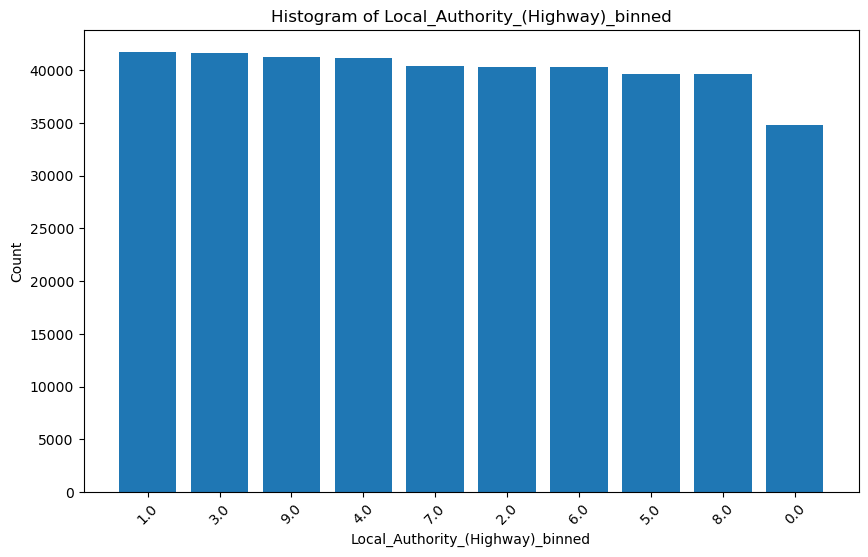

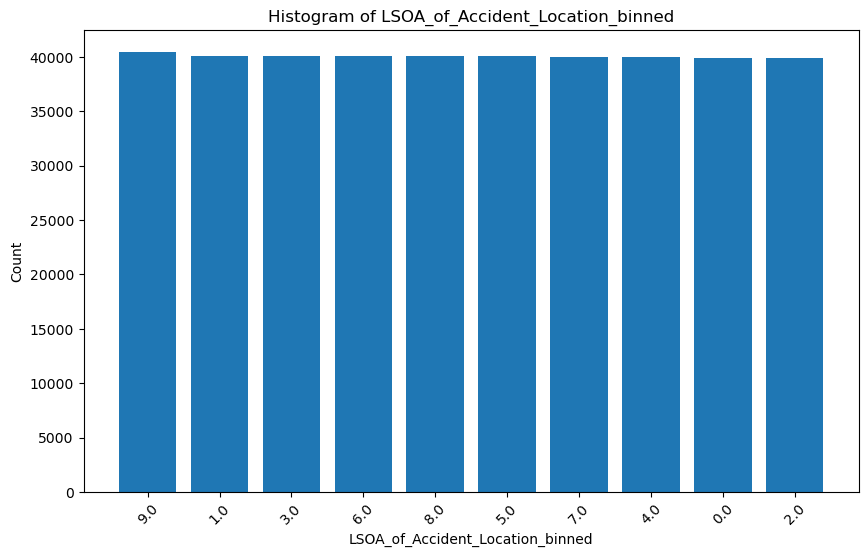

In [105]:

# 6. Create histograms
print("\nCreating histograms...")
categorical_cols = [col for col in wo_onehot_df.columns 
                   if col.endswith("_binned")]
create_histograms(wo_onehot_df, categorical_cols[:2])

# spark.stop()

# 3. Modelovanie - Vytvorenie popisných modelov (3b):

- Vytvorte k-means clustering model
- Pomocou vytvoreného modelu detekujte anomálie
# 4. Modelovanie - Vytvorenie klasifikačných modelov typu (aspoň jeden model každého typu)(4b):

- Decision tree model
- Linear SVM
- Naive Bayes model
- Ensembles of decision trees (Random Forests, Gradient-boosted trees)

# 5. Vyhodnotenie (3b)

- Natrénovanie klasifikačného modelu na trénovacej množine a jeho evaluáciu na testovacej množine.
- Klasifikačný model vyhodnocujte použitím kontigenčnej tabuľky a vypočítaním metrík presnosti, návratnosti, F1 a MCC (Matthews Correlation Coefficient).